<a href="https://colab.research.google.com/github/sayakpaul/Generalized-ODIN-TF/blob/main/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
# Grab the initial model weights
!wget -q https://github.com/sayakpaul/Generalized-ODIN-TF/releases/download/v1.0.0/models.tar.gz
!tar xf models.tar.gz

In [ ]:
!git clone https://github.com/sayakpaul/Generalized-ODIN-TF

In [ ]:
import sys
sys.path.append("Generalized-ODIN-TF")

from scripts import resnet20

from tensorflow.keras import layers
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

tf.random.set_seed(42)
np.random.seed(42)

## Load CIFAR10

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(f"Total training examples: {len(x_train)}")
print(f"Total test examples: {len(x_test)}")

Total training examples: 50000
Total test examples: 10000


## Define constants

In [ ]:
BATCH_SIZE = 128
EPOCHS = 200
START_LR = 0.1
AUTO = tf.data.AUTOTUNE

## Prepare data loaders

In [ ]:
# Augmentation pipeline
simple_aug = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ]
)

# Now, map the augmentation pipeline to our training dataset
train_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
    .map(lambda x, y: (simple_aug(x), y), num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

# Test dataset
test_ds = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## Define LR schedule, optimizer, and loss function

In [ ]:
def lr_schedule(epoch):
    if epoch < int(EPOCHS * 0.25) - 1:
        return START_LR
    elif epoch < int(EPOCHS*0.5) -1:
        return float(START_LR * 0.1)
    elif epoch < int(EPOCHS*0.75) -1:
        return float(START_LR * 0.01)
    else:
        return float(START_LR * 0.001)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr_schedule(epoch), verbose=True)

In [ ]:
# Optimizer and loss function.
optimizer = tf.keras.optimizers.SGD(learning_rate=START_LR, momentum=0.9)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

## Model training with ResNet20

In [ ]:
rn_model = tf.keras.models.load_model("initial_model")
rn_model.compile(loss=loss_fn, optimizer=optimizer, metrics=["accuracy"])
history = rn_model.fit(train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    callbacks=[lr_callback])

Epoch 1/200

Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
391/391 [==============================] - 13s 24ms/step - loss: 2.5417 - accuracy: 0.3458 - val_loss: 2.2469 - val_accuracy: 0.3972
Epoch 2/200

Epoch 00002: LearningRateScheduler reducing learning rate to 0.1.
391/391 [==============================] - 8s 21ms/step - loss: 1.6719 - accuracy: 0.5634 - val_loss: 1.6281 - val_accuracy: 0.5601
Epoch 3/200

Epoch 00003: LearningRateScheduler reducing learning rate to 0.1.
391/391 [==============================] - 8s 21ms/step - loss: 1.3385 - accuracy: 0.6417 - val_loss: 1.9339 - val_accuracy: 0.5281
Epoch 4/200

Epoch 00004: LearningRateScheduler reducing learning rate to 0.1.
391/391 [==============================] - 8s 21ms/step - loss: 1.1944 - accuracy: 0.6821 - val_loss: 1.6186 - val_accuracy: 0.5562
Epoch 5/200

Epoch 00005: LearningRateScheduler reducing learning rate to 0.1.
391/391 [==============================] - 8s 21ms/step - loss: 1.1222 - acc

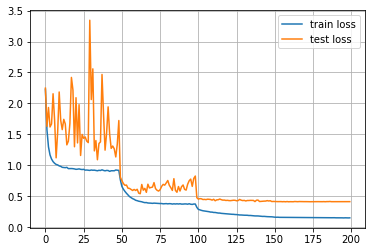

INFO:tensorflow:Assets written to: rn_baseline_model/assets


In [ ]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="test loss")
plt.grid()
plt.legend()
plt.show()

rn_model.save("rn_baseline_model")

In [ ]:
_, train_acc = rn_model.evaluate(train_ds, verbose=0)
_, test_acc = rn_model.evaluate(test_ds, verbose=0)
print("Train accuracy: {:.2f}%".format(train_acc * 100))
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Train accuracy: 99.46%
Test accuracy: 91.42%
